# Analisis Risiko Privasi Dataset Telco Customer Churn

Notebook ini bertujuan untuk menganalisis kerentanan privasi pada dataset `data.csv` sebelum dilakukan proses sintesis data. Analisis mencakup identifikasi variabel sensitif, perhitungan metrik privasi (K-Anonymity), dan visualisasi distribusi data awal.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Konfigurasi visualisasi
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# 1. Load Data
try:
    df = pd.read_csv('data.csv')
    print("Dataset berhasil dimuat.")
    print(f"Dimensi data: {df.shape}")
    display(df.head())
    print(len(df))
except FileNotFoundError:
    print("File 'data.csv' tidak ditemukan. Pastikan file berada di direktori yang sama.")

Dataset berhasil dimuat.
Dimensi data: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


7043


In [3]:
# 2. Identifikasi Variabel

# a. Direct Identifiers: Atribut yang secara unik mengidentifikasi individu (harus dihapus/dienkripsi)
direct_identifiers = ['customerID']

# b. Quasi-Identifiers (QI): Atribut yang jika dikombinasikan dapat mengarah pada re-identifikasi
# Kita memilih subset atribut demografis dan layanan utama sebagai QI untuk analisis ini
quasi_identifiers = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# c. Sensitive Attributes: Informasi sensitif yang ingin dilindungi (target analisis atau data pribadi)
sensitive_attributes = ['Churn', 'Contract', 'MonthlyCharges', 'TotalCharges']

print(f"Direct Identifiers (akan dihapus): {direct_identifiers}")
print(f"Quasi-Identifiers (QI) untuk analisis: {quasi_identifiers}")
print(f"Sensitive Attributes: {sensitive_attributes}")

# Menghapus Direct Identifiers untuk simulasi dataset yang akan diproses
df_anon = df.drop(columns=direct_identifiers)
print("\nDirect identifiers telah dihapus dari dataframe 'df_anon'.")

Direct Identifiers (akan dihapus): ['customerID']
Quasi-Identifiers (QI) untuk analisis: ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
Sensitive Attributes: ['Churn', 'Contract', 'MonthlyCharges', 'TotalCharges']

Direct identifiers telah dihapus dari dataframe 'df_anon'.


In [4]:
# 3. Hitung K-Anonymity

def analyze_k_anonymity(data, qis):
    """
    Menganalisis K-Anonymity berdasarkan Quasi-Identifiers yang dipilih.
    """
    print(f"Menganalisis K-Anonymity untuk QI: {qis}")
    
    # Mengelompokkan data berdasarkan kombinasi nilai QI dan menghitung frekuensinya
    grouped = data.groupby(qis).size().reset_index(name='count')
    
    # Nilai k adalah frekuensi minimum yang ditemukan
    k_actual = grouped['count'].min()
    
    print(f"\nNilai K-Anonymity Dataset: {k_actual}")
    
    if k_actual == 1:
        print("STATUS: HIGH RISK (Risiko Tinggi)")
        print("Alasan: Terdapat setidaknya satu individu yang unik berdasarkan kombinasi QI ini.")
        
        # Menampilkan kombinasi yang unik (berisiko re-identifikasi)
        unique_records = grouped[grouped['count'] == 1]
        print(f"\nJumlah kombinasi unik (record berisiko): {len(unique_records)}")
        print("Contoh kombinasi unik:")
        display(unique_records.head())
    else:
        print(f"STATUS: AMAN (Minimal k={k_actual})")
        print(f"Setiap kombinasi QI muncul setidaknya {k_actual} kali.")

    return k_actual, grouped

# Jalankan analisis
k_val, qi_groups = analyze_k_anonymity(df_anon, quasi_identifiers)

Menganalisis K-Anonymity untuk QI: ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

Nilai K-Anonymity Dataset: 3
STATUS: AMAN (Minimal k=3)
Setiap kombinasi QI muncul setidaknya 3 kali.


C:\Users\ardav\AppData\Local\Temp\ipykernel_13140\1411569144.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, ax=axes[0], palette='viridis')


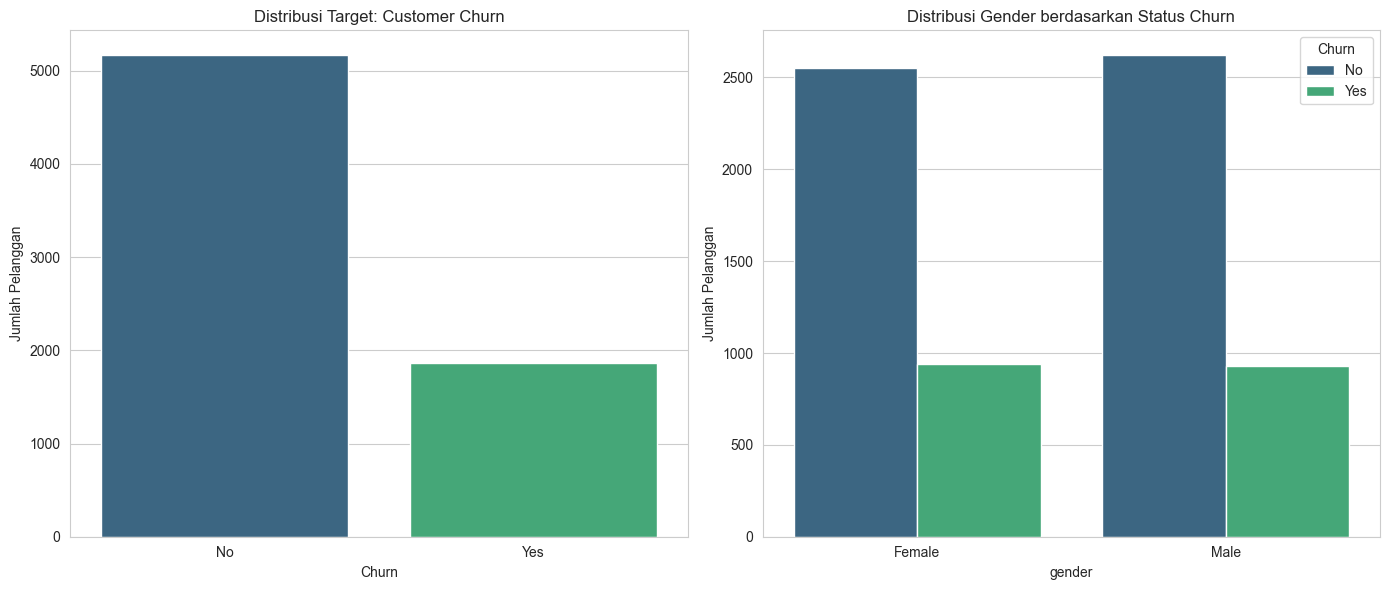

In [5]:
# 4. Visualisasi Awal

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Distribusi Target (Churn)
sns.countplot(x='Churn', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Distribusi Target: Customer Churn')
axes[0].set_ylabel('Jumlah Pelanggan')

# Plot 2: Distribusi Fitur Demografi (Gender) vs Churn
sns.countplot(x='gender', hue='Churn', data=df, ax=axes[1], palette='viridis')
axes[1].set_title('Distribusi Gender berdasarkan Status Churn')
axes[1].set_ylabel('Jumlah Pelanggan')

plt.tight_layout()
plt.show()

In [6]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
